# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Avaliação-e-seleção-de-modelos" data-toc-modified-id="Avaliação-e-seleção-de-modelos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Avaliação e seleção de modelos</a></div><div class="lev2 toc-item"><a href="#Introdução" data-toc-modified-id="Introdução-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introdução</a></div><div class="lev3 toc-item"><a href="#Treinamento-e-teste" data-toc-modified-id="Treinamento-e-teste-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Treinamento e teste</a></div><div class="lev3 toc-item"><a href="#Treinamento,-validação-e-teste" data-toc-modified-id="Treinamento,-validação-e-teste-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Treinamento, validação e teste</a></div><div class="lev3 toc-item"><a href="#Validação-cruzada" data-toc-modified-id="Validação-cruzada-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Validação cruzada</a></div><div class="lev2 toc-item"><a href="#Conjuntos-de-dados" data-toc-modified-id="Conjuntos-de-dados-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Conjuntos de dados</a></div><div class="lev2 toc-item"><a href="#Grid-search" data-toc-modified-id="Grid-search-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Grid-search</a></div><div class="lev3 toc-item"><a href="#Sintonia-de-hiperparâmetros" data-toc-modified-id="Sintonia-de-hiperparâmetros-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Sintonia de hiperparâmetros</a></div><div class="lev3 toc-item"><a href="#Avaliação-de-desempenho" data-toc-modified-id="Avaliação-de-desempenho-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Avaliação de desempenho</a></div><div class="lev2 toc-item"><a href="#Random-search" data-toc-modified-id="Random-search-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Random search</a></div><div class="lev3 toc-item"><a href="#Sintonia-de-hiperparâmetros" data-toc-modified-id="Sintonia-de-hiperparâmetros-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Sintonia de hiperparâmetros</a></div><div class="lev3 toc-item"><a href="#Avaliação-de-desempenho" data-toc-modified-id="Avaliação-de-desempenho-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Avaliação de desempenho</a></div><div class="lev2 toc-item"><a href="#Aprendizado-neste-notebook" data-toc-modified-id="Aprendizado-neste-notebook-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Aprendizado neste notebook</a></div>

# Avaliação e seleção de modelos 

- conjuntos de dados
- busca de hiperparâmetros
- avaliação


## Introdução

### Treinamento e teste

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>


### Treinamento, validação e teste</h2>

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

### Validação cruzada

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse

import sys
import keras
import sklearn
from keras.models import Sequential, load_model, Model
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.regularizers import l2

from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils

print('Keras:  ', keras.__version__)
print('Numpy:  ', np.__version__)
print('Sklearn:', sklearn.__version__)

Using TensorFlow backend.


Keras:   2.0.3
Numpy:   1.12.1
Sklearn: 0.18.1


In [2]:
import os
os.makedirs('../../models',exist_ok=True)

## Conjuntos de dados

- Treinamento 
- Validação
- Testes

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_01.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


In [3]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (TrainingPlotter)

(X_train, y_train_), (X_test, y_test_) = mnist.load_data()

X_train = X_train[y_train_ < 5, ::2, ::2].reshape(-1, 14*14) / 255.0
X_test  = X_test[y_test_ < 5, ::2, ::2].reshape(-1, 14*14) / 255.0
y_train = np_utils.to_categorical(y_train_[y_train_ < 5], 5)
y_test = np_utils.to_categorical(y_test_[y_test_ < 5], 5)

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)

Xtra = X_train[:10000]
ytra = y_train[:10000]
Xtst = X_test[:5000]
ytst = y_test[:5000]

print(Xtra.shape, Xtst.shape)
print(ytra.shape, ytst.shape)

# determina índices para os conjuntos de teste e validação
nn = Xtra.shape[0]
ii = nn // 3
ii_trn, ii_val = np.arange(2*ii), np.arange(2*ii, nn)
print('índices para o treinamento:', ii_trn, ii_trn.shape)
print('índices para a validação:  ', ii_val, ii_val.shape)

n_features = Xtra.shape[1]
n_classes = ytra.shape[1]

(10000, 196) (5000, 196)
(10000, 5) (5000, 5)
índices para o treinamento: [   0    1    2 ..., 6663 6664 6665] (6666,)
índices para a validação:   [6666 6667 6668 ..., 9997 9998 9999] (3334,)


In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

counter = 0

class MyKerasClassifier(KerasClassifier):

    def get_params(self, deep=True):
        return super(MyKerasClassifier, self).get_params()

    def fit(self, X, y, **kwargs):
        global counter
        t0 = time.time()
        
        print('{:3d}: {}'.format(counter, self.filter_sk_params(self.build_fn)), end=' ')
        sys.stdout.flush()
        counter += 1
                
        kw = dict(callbacks=[ModelCheckpoint('../../models/_search_tmp.model', save_best_only=True), 
                             EarlyStopping(patience=15, verbose=0)])
        kw.update(kwargs)
        
        hh = super(MyKerasClassifier, self).fit(X, y, **kw)
        self.model = load_model('../../models/_search_tmp.model')
        
        et = time.time() - t0
        print(' [{:.1f}s]'.format(et))
        return hh
        
    def score(self, X, y, **kwargs):
        score = super(MyKerasClassifier, self).score(X, y, **kwargs)
        print('     score: {}'.format(score))
        return score
    
def make_model(lr=0.01, momentum=0.9, dropout=0.5):
    model = SmallFCNet.build(width=n_features, classes=n_classes, dropout=dropout)
    optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    
    return model

In [5]:
def train_network(optimizer, X_train, y_train, X_test, y_test, dropout=0.5, nepochs=50, ploss=0.25):
    print("[INFO] creating model...")
    model = SmallFCNet.build(width=n_features, classes=n_classes, dropout=dropout)

    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nepochs)
    plot.grid(True)

    print("[INFO] training...")
    try:
        histo2 = model.fit(X_train, y_train, batch_size=128, epochs=nepochs, 
                           verbose=0, validation_split=0.33, callbacks=[histo])
    except KeyboardInterrupt:
        pass

    print("[INFO] evaluating...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))
    
    return model, histo


In [6]:
class SmallFCNet:
    @staticmethod
    def build(width, classes, dropout):
        model = Sequential()        
        model.add(Dense(100, activation='relu', input_dim=width))
        model.add(Dropout(dropout))
        model.add(Dense(classes, activation='softmax'))
        return model


## Grid-search

### Sintonia de hiperparâmetros

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_02.png" alt="Drawing" style="width: 800px;"/> </td></tr>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_03.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


In [7]:
counter = 0
my_classifier = MyKerasClassifier(make_model, batch_size=128, nb_epoch=50, verbose=0)

param_grid = {
    'lr': [0.01, 0.05, 0.1],
    'momentum': [0.9],
    'dropout': [0.2, 0.5, 0.7],
}

validator = GridSearchCV(my_classifier, 
                         param_grid=param_grid, 
                         cv=[(ii_trn, ii_val)],
                         fit_params=dict(validation_data=(X_train[ii_val], y_train[ii_val])))

try:
    validator.fit(X_train, y_train)
    print()
except KeyboardInterrupt:
    pass
else:
    print('The parameters of the best model are: ', validator.best_params_)

  0: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.01}  [2.3s]
     score: 0.9544091181763648
     score: 0.9627962796279628
  1: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.05}  [2.3s]
     score: 0.974505098980204
     score: 0.984998499849985
  2: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.1}  [2.4s]
     score: 0.9784043191361728
     score: 0.9923492349234924
  3: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.01}  [2.5s]
     score: 0.9577084583083383
     score: 0.9635463546354636
  4: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.05}  [2.4s]
     score: 0.9724055188962207
     score: 0.9836483648364837
  5: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.1}  [2.6s]
     score: 0.9763047390521895
     score: 0.98994899489949
  6: {'dropout': 0.7, 'momentum': 0.9, 'lr': 0.01}  [2.5s]
     score: 0.9520095980803839
     score: 0.9584458445844585
  7: {'dropout': 0.7, 'momentum': 0.9, 'lr': 0.05}  [2.8s]
     score: 0.967006598680264
     score: 0.980948094809481
  8: {'dropout': 0.7, 'momentum': 0.9, '

### Avaliação de desempenho

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_04.png" alt="Drawing" style="width: 800px;"/> </td></tr>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_05.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


[INFO] evaluating...
 128/5139 [..............................] - ETA: 0s[INFO] accuracy: 99.42%


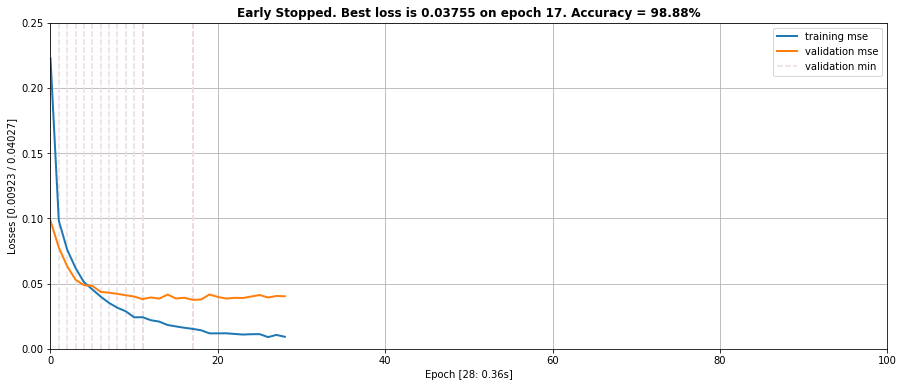

In [8]:
best = validator.best_params_
lr = best['lr']
momentum = best['momentum']
dropout = best['dropout']
optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
model, histo = train_network(optimizer, X_train, y_train, X_test, y_test, 
                             dropout=dropout, nepochs=100, ploss=0.25)

## Random search

### Sintonia de hiperparâmetros

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [9]:
import scipy.stats as st

counter = 0
my_classifier = MyKerasClassifier(make_model, batch_size=128, nb_epoch=50, verbose=0)

param_dist={
    'lr':       st.uniform(0.001, 0.4),
    'momentum': [0.9],
    'dropout':  [0.2, 0.5, 0.7],
}
validator = RandomizedSearchCV(my_classifier, 
                               param_distributions=param_dist, 
                               n_iter=20,
                               cv=[(ii_trn, ii_val)],
                               fit_params=dict(validation_data=(X_train[ii_val], y_train[ii_val])),
                              )

try:
    validator.fit(X_train, y_train)
    print()
except KeyboardInterrupt:
    pass
else:
    print('The parameters of the best model are: ', validator.best_params_)

  0: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.20477035225761431}  [3.1s]
     score: 0.9826034793041392
     score: 0.9978997899789979
  1: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.17130144959120608}  [2.9s]
     score: 0.9826034793041392
     score: 0.995949594959496
  2: {'dropout': 0.7, 'momentum': 0.9, 'lr': 0.17853766904287219}  [3.0s]
     score: 0.9721055788842231
     score: 0.9845484548454846
  3: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.084221452158724064}  [3.4s]
     score: 0.974505098980204
     score: 0.9858985898589859
  4: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.10987259220026158}  [3.2s]
     score: 0.976004799040192
     score: 0.993099309930993
  5: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.34866952920679262}  [3.3s]
     score: 0.980503899220156
     score: 0.9894989498949895
  6: {'dropout': 0.2, 'momentum': 0.9, 'lr': 0.098067116304839955}  [3.4s]
     score: 0.97750449910018
     score: 0.9921992199219922
  7: {'dropout': 0.5, 'momentum': 0.9, 'lr': 0.053354

### Avaliação de desempenho


[INFO] evaluating...
 128/5139 [..............................] - ETA: 0s[INFO] accuracy: 99.28%


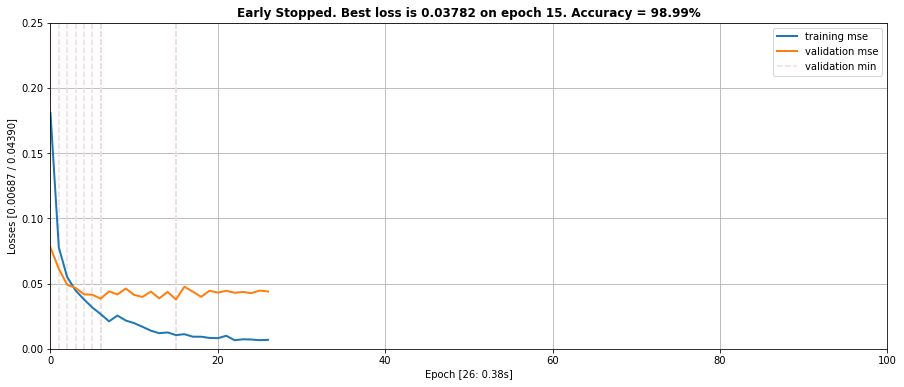

In [10]:
best = validator.best_params_
lr = best['lr']
momentum = best['momentum']
dropout = best['dropout']
optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
model, histo = train_network(optimizer, X_train, y_train, X_test, y_test, 
                             dropout=dropout, nepochs=100, ploss=0.25)

## Aprendizado neste notebook

1. Early stop - não é necessário rodar todas as épocas previstas, quando a rede executada sobre os dados de validação não melhorar mais por n épocas de paciência, o treinamento pára e salva o melhor parâmetro 
2. Busca de hyperparâmetros - conceito de testar vários parâmetros e procurar o melhor deles. Há necessidade de dados de treinamento e de validação. Pode ser exaustivo ou aleatório.
3. Esta implementação utiliza o grid-search do sklearn através do Keras
4. Lembrar que o conjunto de teste não deveria ser utilizado mais que uma vez
